# This notebook creates several summary bar plots to describe how many metabolites were detected

## 1. Run this first section for all plots

In [1]:
from pathlib import Path
from definitions import ROOT_DIR
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import rc
rc('font',**{'family':'sans-serif',
             'sans-serif':['Arial'],
             'size':16})
from matplotlib.ticker import MaxNLocator
from textwrap import wrap
import seaborn as sns
from plotnine import *

In [2]:
def filter_neutral_losses(df, neutral_losses=['']):
    '''
    Filter out entries for ions with neutral losses that are not in the list provided
    If neutral_loss value us "only_nl", than consider only ions that have neutral losses
    '''
    
    if neutral_losses == "only_nl":
        df = df[df.neutral_loss != ""]
    elif neutral_losses != None:
        df = df[df.neutral_loss.isin(neutral_losses)]
    return df


def filter_adducts(df, adducts=['']):
    '''
    Filter out entries for ions with adducts that are not in the list provided
    '''
    if adducts != None:
        df = df[df.adduct.isin(adducts)]
    return df


def filter_polarity(df, polarity=None):
    '''
    Filter out entries based on polarity pol ['positive', 'negative']
    '''
    if polarity != None:
        df = df[df.Polarity == polarity]
    return df


def filter_data(data, polarity=None, adducts=None, neutral_losses=None):
    '''
    Apply polarity, adduct and neutral_loss filters
    '''
    data = filter_polarity(data, polarity)
    data = filter_adducts(data, adducts)
    data = filter_neutral_losses(data, neutral_losses)
    return data

def group_by_metabolite(df, threshold=0.8):
    '''
    Aggregate detection values per metabolite
    '''
    
    df['detectability'] = df.pred_val >= threshold
            
    
    data = df.pivot_table(index='name_short',
                          columns='Matrix short',
                          values='detectability',
                          aggfunc='max',
                          fill_value=False)
    return data

def sum_detections_per_metabolite(data):
    
    data['detected_by_n_methods'] = data.sum(axis=1)
    data = data.reset_index()
    data.sort_values(by='detected_by_n_methods', ascending=False, inplace=True)
    
    return data

def prep_plot_data(data, polarity=None, neutral_losses=None):
    '''
    '''
    data = filter_data(data, polarity=polarity, neutral_losses=neutral_losses)
    data = group_by_metabolite(data)
    data = sum_detections_per_metabolite(data)
    
    return data

- Inputs

In [3]:
p_root_dir = Path(ROOT_DIR).parents[0]
p_data = p_root_dir / "5_data_analysis"
p_out = p_root_dir / "6_plots/q2_plots/barplots"

# Compounds name and ID information
p_compounds = p_data / "compounds_ids.csv"

# Metrics and Catboost predictions for all ions in their target wells
p_predictions = p_data / "all_predictions_curated_11-Dec-2021.csv"

# Dataset info (lab, matrix, polarity, m/z range, ids, etc.)
p_datasets = p_data / "Datasets_14Jul2022.csv"

# Classification
p_chem_class = p_data / "custom_classification_v2.csv"
p_pathways = p_data / "pathways_v2.csv"

- Load and merge predictions with dataset metadata

In [4]:
# Load predictions, format neutral loss column
predictions = pd.read_csv(p_predictions, index_col=0)[['dataset_id', 
                                                       'name_short', 
                                                       'adduct', 
                                                       'neutral_loss', 
                                                       'pred_val',
                                                       'spot_intensity_bgr_corrected']]
predictions.neutral_loss.fillna('', inplace=True)

# Add dataset metadata 
datasets = pd.read_csv(p_datasets)
datasets_info = datasets.groupby('Dataset ID').first()[['Polarity', 'Matrix short', 'Matrix long', 'Slide code', 'EMBL']]
datasets_info['sample_name'] = datasets_info['Matrix short']

# Merge with predictions
df = pd.merge(predictions, datasets_info, left_on='dataset_id', right_on='Dataset ID', how='left')

- Load compound metadata and classification

In [5]:
compounds = pd.read_csv(p_compounds, index_col='internal_id')
compounds = compounds[compounds.hmdb_primary != 'custom'][['name_short']] # to exclude thermometer ions

## 2. How many methods detect each compound

In [6]:
def make_bar_plot(plot_data, title):
    # this figure is good for zooming in and studying trends
    fig, ax = plt.subplots(figsize=(40,15))
    g = sns.barplot(x='name_short', y=f'detected_by_n_methods', data=plot_data, ax=ax, color='k')
    
    # appearance
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    g.set_xlabel(None) # hide axes labels
    
    g.set_yticklabels(g.get_yticks(), size=30)
    g.set_ylabel('Number of protocols detecting copmpound', fontsize=30) 
    g.set_title(title, fontsize=35)

    return g

def make_bar_plot_figure(plot_data, title=""):
    # this figure is good for print
    fig, ax = plt.subplots(figsize=(8,4))
    g = sns.barplot(x='name_short', y='detected_by_n_methods', data=plot_data, ax=ax, color='grey')
    
    # Edit axes
    g.set(xlabel='Metabolites', xticklabels='', ylabel = "\n".join(wrap('Number of protocols detecting the metabolite', 25)), title=title)
#     g.tick_params(left=True, bottom=False)
#     g.yaxis.set_major_locator(MaxNLocator(integer=True))
    # Edit plot area
    sns.despine()
    plt.tight_layout()

    return g

- Make a test plot

In [7]:
# prepare data
polarity='negative'
plot_data = prep_plot_data(data=df,
#                            polarity=polarity, # positive, negative
                           neutral_losses=[''])

# Print stats
print(f"Stats for {polarity} polarity/ies: \n")
print(f"{sum(plot_data.detected_by_n_methods > 0)} out of {sum(~plot_data.detected_by_n_methods.isna())} metabolites were detected")
print(f"This is {int(100*sum(plot_data.detected_by_n_methods > 0) / sum(~plot_data.detected_by_n_methods.isna()))}%  \n")
print(f"{sum(plot_data.detected_by_n_methods == 12)} metabolites were detected by all methods")
print(f"These metabolites are {plot_data.name_short[plot_data.detected_by_n_methods == 12].values} \n")
print(f"Half of the compounds were deteced by {np.floor(plot_data.detected_by_n_methods.describe()[5])} or more protocols \n")
print(f"{sum(plot_data.detected_by_n_methods == 0)} metabolites were not detected")
print(f"These metabolites are {plot_data.name_short[plot_data.detected_by_n_methods == 0].values} \n")

## make plots
# make_bar_plot(plot_data, title='Test plot')
# make_bar_plot_figure(plot_data, title='Test plot')

Stats for negative polarity/ies: 

161 out of 172 metabolites were detected
This is 93%  

11 metabolites were detected by all methods
These metabolites are ['Arginine' 'GlcCer d18:1/18:0' 'PC 15:0-18:1' 'Thymine'
 'Taurocholic acid' 'Choline' 'Sulfo GalCer 18:0(2S-OH)' 'Spermidine'
 'Acetylcholine' 'Malic acid' 'Lyso PI 17:1'] 

Half of the compounds were deteced by 9.0 or more protocols 

11 metabolites were not detected
These metabolites are ['Phosphoserine' 'Indole' 'Cholesteryl acetate' 'Lactic acid'
 'Dihydroxyacetone' 'Carbamoyl phosphate' 'Pyruvic acid'
 'Acetoacetic acid' 'Cholesterol' 'Butyric acid' 'Arachidonic acid'] 



<ipython-input-2-20969cabed99>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


- Bulk save plots for combinations of the following parameters:
1. Ionisation mode: positive, negative or both combined
2. Neutral losses included of excluded

In [8]:
for neutral_losses in [[""]]: #[None, [''], 'only_nl']:
    
    nl_label = 'with n.l.'
    if neutral_losses == [""]: 
        nl_label = 'no n.l.'  
    elif neutral_losses == 'only_nl':
        nl_label = 'only n.l.'     
    
    for polarity in ['positive', 'negative', None]:
        
        # Prepare data to plot      
        plot_data = prep_plot_data(data=df,
                           polarity=polarity,
                           neutral_losses=neutral_losses)
        
        
        # Make the plot
        title = f"Detailed plot - selected by n methods {nl_label} {polarity}"
        g = make_bar_plot(plot_data, title=title)

        # Save the plot
        g.figure.savefig(p_out / "n_methods_detecting_metabolite" / f"{title}.png")
        g.figure.savefig(p_out / "n_methods_detecting_metabolite" / f"{title}.pdf")
        plt.close()  

<ipython-input-6-41f317a1635c>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
<ipython-input-6-41f317a1635c>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
<ipython-input-2-20969cabed99>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-6-41f317a1635c>:10: UserWarning: FixedFormatter should only be used together with FixedLocator


In [9]:
for neutral_losses in [[""]]:
    
    nl_label = 'with n.l.'
    if neutral_losses == [""]: 
        nl_label = 'no n.l.'  
    elif neutral_losses == 'only_nl':
        nl_label = 'only n.l.'         
    
    for polarity in ['positive', 'negative', None]:
        
        polarity_label = 'Both ionisation modes'
        if polarity == 'positive':
            polarity_label = 'Positive ionisation mode'
        elif polarity == 'negative':
            polarity_label = 'Negative ionisation mode' 
        
        # Prepare data to plot      
        plot_data = prep_plot_data(data=df,
                           polarity=polarity,
                           neutral_losses=neutral_losses)

        # Make the plot
        fname = f"Figure - selected by n methods {nl_label} {polarity}"
        title = f"{polarity_label}"
        g = make_bar_plot_figure(plot_data, title=title)

#         Save the plot
        g.figure.savefig(p_out / "n_methods_detecting_metabolite" / f"{fname}.png")
        g.figure.savefig(p_out / "n_methods_detecting_metabolite" / f"{fname}.pdf")
        plt.close()  

<ipython-input-2-20969cabed99>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## 3. Detections summarised by pathway

In [64]:
def stacked_barplot(data, category_column, category_name, aspect_ratio=1, title=""):
    p = (ggplot(data)    # defining what data to use
     + aes(x=category_column)    # defining what variable to use
     + geom_bar(aes(fill = 'detected'), linetype='solid', color='black') # defining the type of plot to use
     + coord_flip()
     + labs(x = category_name, y = "Number of compounds", fill = "Detected?", title=title)
     + theme_classic()
     + theme(
         aspect_ratio=aspect_ratio,
             text=element_text(family = 'sans-serif', size=16, color='black'),
             title=element_text(family = 'sans-serif', size=18))
     + scale_fill_manual(['white', 'grey'])
    )

    return p

### Plot with fine pathways

In [11]:
# Map compounds to pathways
pathways = pd.read_csv(p_pathways)
fine_path_map = compounds.merge(pathways.drop(['main_coarse_path'], axis=1), how='left', on='name_short')

- Order compounds first by coarse path (alphabetically), then by fine path (largest to smallest), so that the bars in th bar plot are arranged correctly

In [12]:
fine_path_map['n_molecules'] = 1

grouped_fine_path_map = fine_path_map.groupby(['fine_path']).agg({
    'coarse_path':'first',
    'n_molecules':'count'
})

# Sort coarse paths in alphabetical order
coarse_paths = np.sort(fine_path_map.coarse_path.unique())

# Fine path by number of molecules
custom_order = [grouped_fine_path_map[grouped_fine_path_map.coarse_path == x].sort_values('n_molecules', ascending=False).index.values for x in coarse_paths]
custom_order = list(np.concatenate(custom_order)) #convert to list

# Get the correct row order for ungrouped dataframe
order_column = [custom_order.index(x) for x in fine_path_map.fine_path]
fine_path_map['order'] = order_column

# Reorder rows of dataframe
fine_path_map_sorted = fine_path_map.sort_values('order', ascending = False)

# Convert path column values to categorical
# Without this step plotnine will ignore row order in the dataframe
fine_path_map_sorted['fine_path'] = pd.Categorical(fine_path_map_sorted.fine_path, categories=pd.unique(fine_path_map_sorted.fine_path))

- Make a test plot

<ipython-input-13-a46b6750eb10>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-13-a46b6750eb10>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


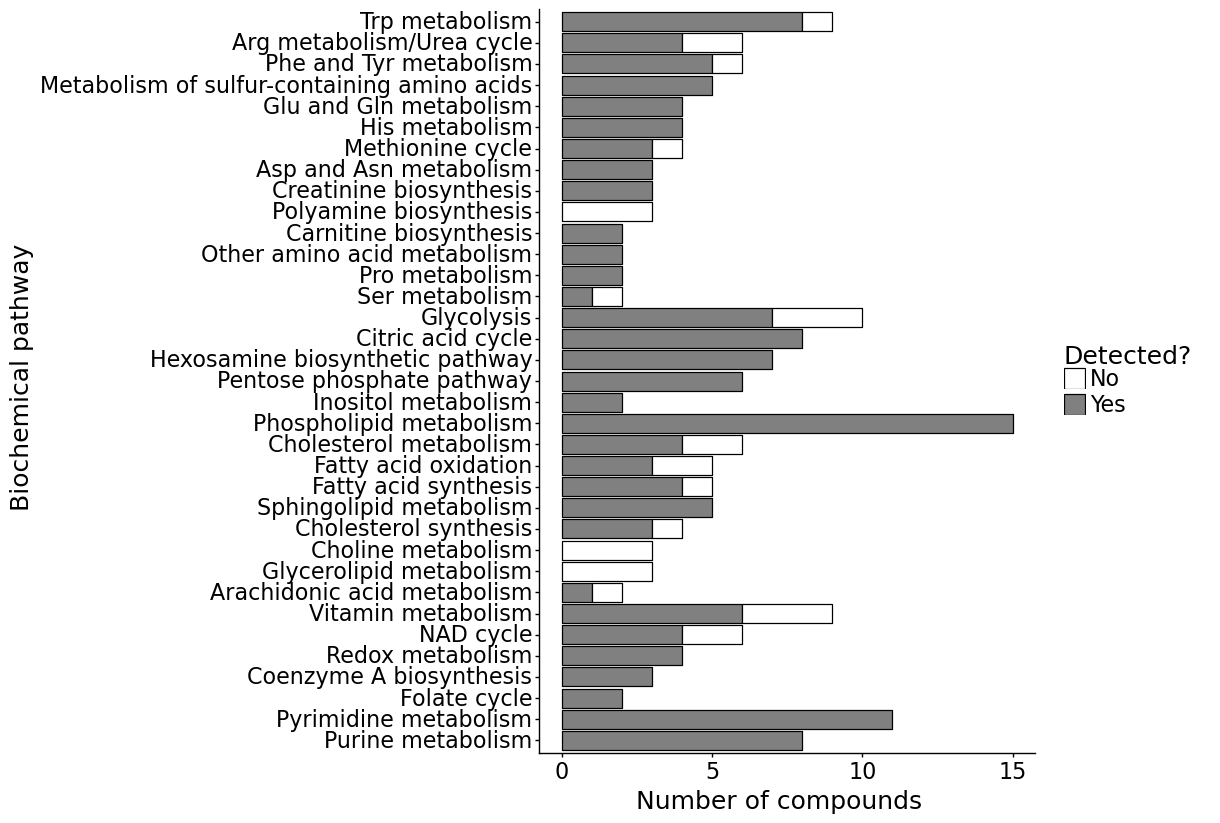

<ggplot: (85979626159)>

In [13]:
# Prepare data
plot_data = prep_plot_data(data=df,
                      polarity='negative',
                      neutral_losses=[''])

# Map data to classification
detection_df = plot_data[['name_short', 'detected_by_n_methods']]
detection_df['detected'] = detection_df['detected_by_n_methods'] > 0
detection_df['detected'] = ['Yes' if x==True else 'No' for x in detection_df['detected']]
stacked_data = fine_path_map_sorted.merge(detection_df, how='left', on='name_short')

# Plot data
stacked_barplot(stacked_data, category_column='fine_path', category_name='Biochemical pathway', aspect_ratio=1.5)

In [14]:
for neutral_losses in [['']]: #[None, [''], 'only_nl']:
    
    nl_label = 'with n.l.'
    if neutral_losses == ['']: 
        nl_label = 'no n.l.'  
    elif neutral_losses == 'only_nl':
        nl_label = 'only n.l.'  

    for polarity in ['positive', 'negative', None]:
        
        polarity_label = 'Both ionisation modes'
        if polarity == 'positive':
            polarity_label = 'Positive ionisation mode'
        elif polarity == 'negative':
            polarity_label = 'Negative ionisation mode'  
        

        # Prepare data
        plot_data = prep_plot_data(data=df,
                              polarity=polarity,
                              neutral_losses=neutral_losses)

        # Map data to classification
        detection_df = plot_data[['name_short', 'detected_by_n_methods']]
        detection_df['detected'] = detection_df['detected_by_n_methods'] > 0
        detection_df['detected'] = ['Yes' if x==True else 'No' for x in detection_df['detected']]
        stacked_data = fine_path_map_sorted.merge(detection_df, how='left', on='name_short')

        # Plot data
        fname = f"Coverage per fine_path {polarity} {nl_label}"
        title = polarity_label
        p = stacked_barplot(stacked_data, 'fine_path', 'Biochemical pathway', aspect_ratio=1.7, title=title)

        # Save the plot
        p.save(p_out / "detection_per_pathway" / f"{fname}.png")
        save_as_pdf_pages([p], p_out / "detection_per_pathway" / f"{fname}.pdf")
        plt.close()  

<ipython-input-14-011d1983479e>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-14-011d1983479e>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: d:\saharuka\spotting\spotting_git\matrix_comparison\6_plots\q2_plots\barplots\detection_per_pathway\Coverage per fine

### Plot with coarse pathways

In [15]:
# Map conpounds to pathways
coarse_path_map = compounds.merge(pathways.drop(['coarse_path', 'fine_path'], axis=1).drop_duplicates(), how='left', on='name_short')

- Make a test plot

<ipython-input-16-f8659a78c458>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-16-f8659a78c458>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


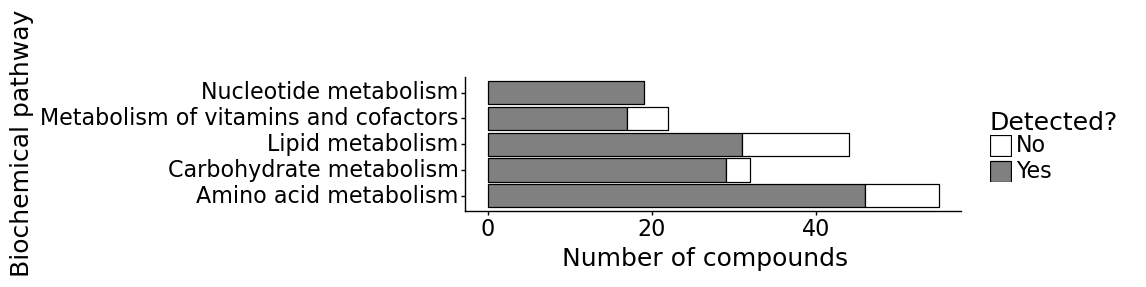

<ggplot: (85980331081)>

In [16]:
# Prepare data
plot_data = prep_plot_data(data=df,
                      polarity='negative', 
                      neutral_losses=[''])

# Map data to classification
detection_df = plot_data[['name_short', 'detected_by_n_methods']]
detection_df['detected'] = detection_df['detected_by_n_methods'] > 0
detection_df['detected'] = ['Yes' if x==True else 'No' for x in detection_df['detected']]
stacked_data = coarse_path_map.merge(detection_df, how='left', on='name_short')

# Plot data
stacked_barplot(stacked_data, 'main_coarse_path', 'Biochemical pathway', aspect_ratio=0.27)

- Save plots in a batch mode changing polarity filter settings

In [17]:
for neutral_losses in [['']]: #[None, [''], 'only_nl']:
    
    nl_label = 'with n.l.'
    if neutral_losses == ['']: 
        nl_label = 'no n.l.'  
    elif neutral_losses == 'only_nl':
        nl_label = 'only n.l.'  

    for polarity in ['positive', 'negative', None]:
        
        polarity_label = 'Both ionisation modes'
        if polarity == 'positive':
            polarity_label = 'Positive ionisation mode'
        elif polarity == 'negative':
            polarity_label = 'Negative ionisation mode'  
        

        # Prepare data
        plot_data = prep_plot_data(data=df,
                              polarity=polarity,
                              neutral_losses=neutral_losses)

        # Map data to classification
        detection_df = plot_data[['name_short', 'detected_by_n_methods']]
        detection_df['detected'] = detection_df['detected_by_n_methods'] > 0
        detection_df['detected'] = ['Yes' if x==True else 'No' for x in detection_df['detected']]
        stacked_data = coarse_path_map.merge(detection_df, how='left', on='name_short')

        # Plot data
        fname = f"Coverage per coarse_path {polarity} {nl_label}"
        title = polarity_label
        p = stacked_barplot(stacked_data, 'main_coarse_path', 'Biochemical pathway', aspect_ratio=0.3, title=title)
        
        # Save the plot
        p.save(p_out / "detection_per_pathway" / f"{fname}.png")
        save_as_pdf_pages([p], p_out / "detection_per_pathway" / f"{fname}.pdf")
        plt.close()  

<ipython-input-17-33cabaaa0a77>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-17-33cabaaa0a77>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: d:\saharuka\spotting\spotting_git\matrix_comparison\6_plots\q2_plots\barplots\detection_per_pathway\Coverage per coar

## 4. Detections summarised by class

### Plot with fine classes

In [18]:
classes = pd.read_csv(p_chem_class, index_col='internal_id')

# Map compounds to pathways
fine_class_map = compounds.merge(classes.drop(['main_coarse_class'], axis=1), how='left', on='name_short')

- Order compounds first by coarse class (alphabetically), then by fine class (largest to smallest), so that the bars in th bar plot are arranged correctly

In [41]:
fine_class_map['n_molecules'] = 1

grouped_fine_class_map = fine_class_map.groupby(['fine_class']).agg({
    'coarse_class':'first',
    'n_molecules':'count'
})

# Sort coarse paths in alphabetical order
coarse_classes = np.sort(fine_class_map.coarse_class.unique())

# Fine path by number of molecules
custom_order = [grouped_fine_class_map[grouped_fine_class_map.coarse_class == x].sort_values('n_molecules', ascending=False).index.values for x in coarse_classes]
custom_order = list(np.concatenate(custom_order)) #convert to list

# Get the correct row order for ungrouped dataframe
order_column = [custom_order.index(x) for x in fine_class_map.fine_class]
fine_class_map['order'] = order_column

# Reorder rows of dataframe
fine_class_map_sorted = fine_class_map.sort_values('order', ascending = False)

# Convert path column values to categorical
# Without this step plotnine will ignore row order in the dataframe
fine_class_map_sorted['fine_class'] = pd.Categorical(fine_class_map_sorted.fine_class, categories=pd.unique(fine_class_map_sorted.fine_class))

- Make a test plot

<ipython-input-42-da195ae8fd38>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-42-da195ae8fd38>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


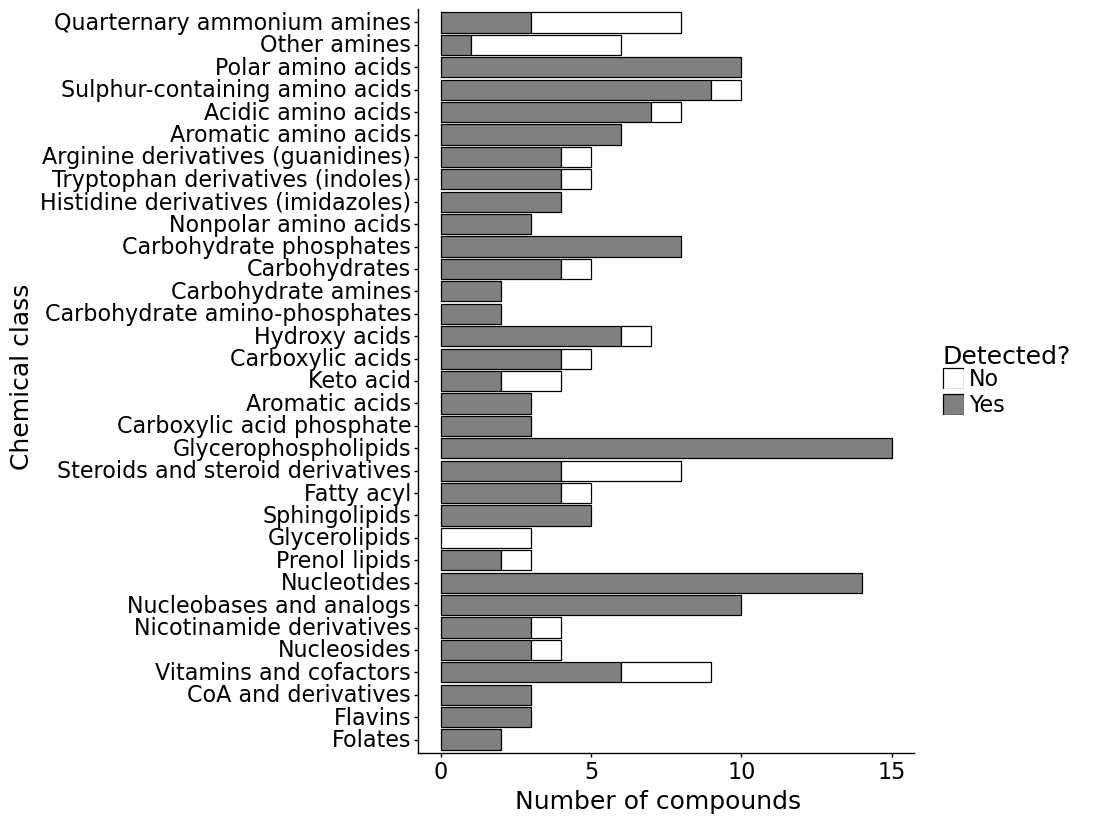

<ggplot: (85981564886)>

In [42]:
# Prepare data
plot_data = prep_plot_data(data=df,
                      polarity='negative',
                      neutral_losses=[''])

# Map data to classification
detection_df = plot_data[['name_short', 'detected_by_n_methods']]
detection_df['detected'] = detection_df['detected_by_n_methods'] > 0
detection_df['detected'] = ['Yes' if x==True else 'No' for x in detection_df['detected']]
stacked_data = fine_class_map_sorted.merge(detection_df, how='left', on='name_short')

# Plot data
stacked_barplot(stacked_data, 'fine_class', 'Chemical class', aspect_ratio=1.5)

- Batch save plots

In [21]:
for neutral_losses in [['']]: #[None, [''], 'only_nl']:
    
    nl_label = 'with n.l.'
    if neutral_losses == ['']: 
        nl_label = 'no n.l.'  
    elif neutral_losses == 'only_nl':
        nl_label = 'only n.l.'  

    for polarity in ['positive', 'negative', None]:
        
        polarity_label = 'Both ionisation modes'
        if polarity == 'positive':
            polarity_label = 'Positive ionisation mode'
        elif polarity == 'negative':
            polarity_label = 'Negative ionisation mode'  
        

        # Prepare data
        plot_data = prep_plot_data(data=df,
                              polarity=polarity,
                              neutral_losses=neutral_losses)

        # Map data to classification
        detection_df = plot_data[['name_short', 'detected_by_n_methods']]
        detection_df['detected'] = detection_df['detected_by_n_methods'] > 0
        detection_df['detected'] = ['Yes' if x==True else 'No' for x in detection_df['detected']]
        stacked_data = fine_class_map_sorted.merge(detection_df, how='left', on='name_short')

        # Plot data
        fname = f"Coverage per fine_class {polarity} {nl_label}"
        title = polarity_label
        p = stacked_barplot(stacked_data, 'fine_class', 'Chemical subclass', aspect_ratio=1.6, title=title)

        # Save the plot
        p.save(p_out / "detection_per_chemical_class" / f"{fname}.png")
        save_as_pdf_pages([p], p_out / "detection_per_chemical_class" / f"{fname}.pdf")
        plt.close()  

<ipython-input-21-ab53f1c812c7>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-21-ab53f1c812c7>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: d:\saharuka\spotting\spotting_git\matrix_comparison\6_plots\q2_plots\barplots\detection_per_chemical_class\Coverage p

### Plot with coarse classes

In [57]:
# Map conpounds to pathways
coarse_class_map = compounds.merge(classes.drop(['coarse_class', 'fine_class'], axis=1).drop_duplicates(), how='left', on='name_short')
coarse_class_map.main_coarse_class = pd.Categorical(coarse_class_map.main_coarse_class, categories=pd.unique(coarse_class_map.main_coarse_class.sort_values(ascending=False)))

- Make test plot

<ipython-input-67-c0ed78f0e4e2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-67-c0ed78f0e4e2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


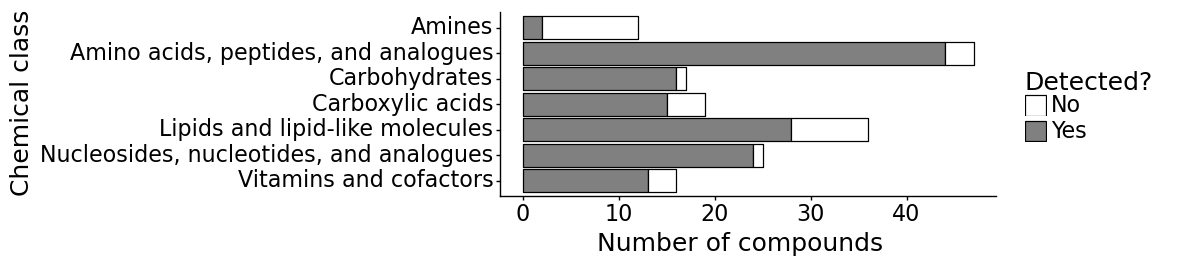

<ggplot: (85988225428)>

In [67]:
# Prepare data
plot_data = prep_plot_data(data=df,
                      polarity='negative',
                      neutral_losses=[''])

# Map data to classification
detection_df = plot_data[['name_short', 'detected_by_n_methods']]
detection_df['detected'] = detection_df['detected_by_n_methods'] > 0
detection_df['detected'] = ['Yes' if x==True else 'No' for x in detection_df['detected']]
plot_data = coarse_class_map.merge(detection_df, how='left', on='name_short')

# Plot data
stacked_barplot(plot_data, 'main_coarse_class', 'Chemical class', aspect_ratio=0.37)

- Batch save plots

In [68]:
for neutral_losses in [['']]: #[None, [''], 'only_nl']:
    
    nl_label = 'with n.l.'
    if neutral_losses == ['']: 
        nl_label = 'no n.l.'  
    elif neutral_losses == 'only_nl':
        nl_label = 'only n.l.'  

    for polarity in ['positive', 'negative', None]:
        
        polarity_label = 'Both ionisation modes'
        if polarity == 'positive':
            polarity_label = 'Positive ionisation mode'
        elif polarity == 'negative':
            polarity_label = 'Negative ionisation mode'  
        

        # Prepare data
        plot_data = prep_plot_data(data=df,
                              polarity=polarity,
                              neutral_losses=neutral_losses)
        
        # Map data to classification
        detection_df = plot_data[['name_short', 'detected_by_n_methods']]
        detection_df['detected'] = detection_df['detected_by_n_methods'] > 0
        detection_df['detected'] = ['Yes' if x==True else 'No' for x in detection_df['detected']]
        stacked_data = coarse_class_map.merge(detection_df, how='left', on='name_short')

        # Plot data
        fname = f"Coverage per coarse_class {polarity} {nl_label}"
        title = polarity_label
        p = stacked_barplot(stacked_data, 'main_coarse_class', 'Chemical class', aspect_ratio=0.4, title=title)

        # Save the plot
        p.save(p_out / "detection_per_chemical_class" / f"{fname}.png")
        save_as_pdf_pages([p], p_out / "detection_per_chemical_class" / f"{fname}.pdf")
        plt.close()  

<ipython-input-68-7c33e56afc2b>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-68-7c33e56afc2b>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: d:\saharuka\spotting\spotting_git\matrix_comparison\6_plots\q2_plots\barplots\detection_per_chemical_class\Coverage p

## 5. Detections summarised by matrix

In [237]:
def prep_plot_data(data, polarity=None, neutral_losses=None):
    '''
    '''
    data = filter_data(data, polarity=polarity, neutral_losses=neutral_losses)
    data = group_by_metabolite(data)
    data = data.unstack(level=0).reset_index()
    data.columns = ['Matrix short', 'name_short', 'detected']
    
    return data

- Make a test plot

<ipython-input-203-b677087117a5>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


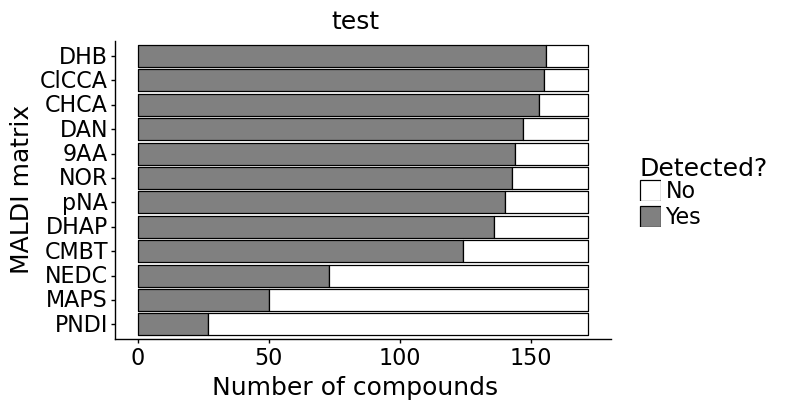

<ggplot: (153494618176)>

In [274]:
# Prepare data
plot_data = prep_plot_data(data=df,
                      polarity=None, 
                      neutral_losses=[''])

# Define Y axis order
matrices_in_order = plot_data.groupby(['Matrix short']).agg({'detected':'sum'}).sort_values(by='detected', ascending=True).index
plot_data['Matrix short'] = pd.Categorical(plot_data['Matrix short'], categories=matrices_in_order)

# Change labels
plot_data['detected'] = ['Yes' if x==True else 'No' for x in plot_data['detected']]

# Test plot
stacked_barplot(plot_data, 'Matrix short', 'MALDI matrix', aspect_ratio=0.6, title='test')

- Batch save plots

In [275]:
for neutral_losses in [['']]: #[None, [''], 'only_nl']:
    
    nl_label = 'with n.l.'
    if neutral_losses == ['']: 
        nl_label = 'no n.l.'  
    elif neutral_losses == 'only_nl':
        nl_label = 'only n.l.'  

    for polarity in ['positive', 'negative', None]:
        
        polarity_label = 'Both ionisation modes'
        if polarity == 'positive':
            polarity_label = 'Positive ionisation mode'
        elif polarity == 'negative':
            polarity_label = 'Negative ionisation mode'  
        

        # Prepare data
        plot_data = prep_plot_data(data=df,
                              polarity=polarity,
                              neutral_losses=neutral_losses)
        
            
        # Define Y axis order
        matrices_in_order = plot_data.groupby(['Matrix short']).agg({'detected':'sum'}).sort_values(by='detected', ascending=True).index
        plot_data['Matrix short'] = pd.Categorical(plot_data['Matrix short'], categories=matrices_in_order)

        # Change labels
        plot_data['detected'] = ['Yes' if x==True else 'No' for x in plot_data['detected']]

        # Plot data
        fname = f"Coverage per matrix {polarity} {nl_label}"
        title = f"{polarity_label}"
        p = stacked_barplot(plot_data, 'Matrix short', 'MALDI matrix', aspect_ratio=0.6, title=title)

        # Save the plot
        p.save(p_out  / "detection_per_matrix" / f"{fname}.png")
        save_as_pdf_pages([p], p_out / "detection_per_matrix" / f"{fname}.pdf")
        plt.close()  

C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: d:\saharuka\spotting\20_matrices_git\spotting\analysis\20_matrices\6_plots\q2_plots\barplots\detection_per_matrix\Coverage per matrix positive no n.l..png
C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\plotnine\ggplot.py:820: PlotnineWarning: Filename: d:\saharuka\spotting\20_matrices_git\spotting\analysis\20_matrices\6_plots\q2_plots\barplots\detection_per_matrix\Coverage per matrix positive no n.l..pdf
C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: d:\saharuka\spotting\20_matrices_git\spotting\analysis\20_matrices\6_plots\q2_plots\barplots\detection_per_matr